#### Author: Artem Golotin
##### Lab 6

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Define global functions
def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)


In [3]:
# Define data that will be used globally
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Declare plotting function
import matplotlib.pyplot as plt

def plot_accuracy(baseline, x, train_y, test_y, title=None, xlabel="Keep Probability"):
    plt.plot(x, train_y, label='Training Accuracy')
    plt.plot(x, test_y, label='Testing Accuracy')
    plt.axhline(y=baseline, color='r', ls='dashed', label='Baseline')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classification Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

###### Baseline

In [6]:
# Declare computation graph for baseline
def run_baseline():
    y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
    x = tf.placeholder( tf.float32, [None, 784], name="x" )

    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    h1 = tf.nn.relu(tf.matmul( x, W1 ) + b1)

    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    h2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)

    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    h3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)

    W4 = weight_variable([1000, 10])
    b4 = bias_variable([10])
    y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
    xent_summary = tf.scalar_summary( 'xent', cross_entropy )

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc_summary = tf.scalar_summary( 'accuracy', accuracy )

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    #
    # ==================================================================
    #

    sess = tf.Session()
    sess.run( tf.initialize_all_variables() )

    #
    # ==================================================================
    #

    for i in tqdm(range(150)):
        sess.run(train_step, feed_dict={ x: images, y_: labels })

    return sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels } )

BASELINE_ACC = run_baseline()
print( "BASELINE ACCURACY %g" % BASELINE_ACC )

100%|██████████| 150/150 [01:35<00:00,  1.96it/s]


BASELINE ACCURACY 0.85


###### Dropout

In [7]:
##### Reset the graph #####
tf.reset_default_graph()

keep_probs = [ 0.1, 0.25, 0.5, 0.75, 1.0 ]
train_acc = []
test_acc = []

def run_dropout():
    # Declare new computation graph
    y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
    x = tf.placeholder( tf.float32, [None, 784], name="x" )
    keep_probability = tf.placeholder(tf.float32)
    scale = tf.placeholder(tf.float32)

    ####### H1 #########
    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    H1 = tf.nn.relu(tf.matmul( x, W1 ) + b1)
    # Dropout
    U1 = tf.to_float(tf.less(tf.random_uniform(tf.shape(H1)), keep_probability))
    h1 = tf.mul(H1, U1)

    ####### H2 #########
    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    H2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)
    # Dropout
    U2 = tf.to_float(tf.less(tf.random_uniform(tf.shape(H2)), keep_probability))
    h2 = tf.mul(H2, U2)


    ####### H3 #########
    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    H3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)
    # Dropout
    U3 = tf.to_float(tf.less(tf.random_uniform(tf.shape(H3)), keep_probability))
    h3 = tf.mul(H3, U3)

    W4 = weight_variable([1000, 10])
    b4 = bias_variable([10])
    # Scale the activations by keep_prob
    y_hat = tf.mul(tf.nn.softmax(tf.matmul(h3, W4) + b4), scale)


    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
    xent_summary = tf.scalar_summary( 'xent', cross_entropy )

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc_summary = tf.scalar_summary( 'accuracy', accuracy )

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    #
    # ==================================================================
    #

    sess = tf.Session()
    for p in keep_probs:
        # I checked, this will for sure reinitilize all of the tensors to entirely new values
        sess.run(tf.initialize_all_variables())
        for _ in tqdm(range(150)):
            sess.run(train_step, feed_dict={ x: images, y_: labels, keep_probability: p, scale: p } )

        t_acc = sess.run(accuracy, feed_dict={ x: images, y_: labels, keep_probability: 1.0, scale: p })
        final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, keep_probability: 1.0, scale: p } )
        train_acc.append(t_acc)
        test_acc.append(final_acc)
        
run_dropout()

100%|██████████| 150/150 [01:11<00:00,  2.15it/s]


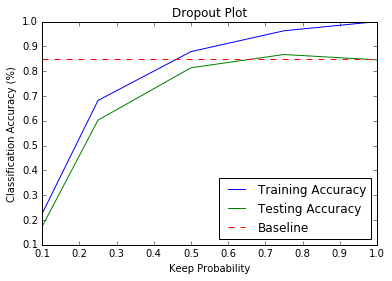

In [8]:
%matplotlib inline
plot_accuracy(BASELINE_ACC, keep_probs, train_acc, test_acc, title="Dropout Plot")

###### Dropconnect

In [12]:
##### Reset the graph #####
tf.reset_default_graph()

keep_probs = [ 0.1, 0.25, 0.5, 0.75, 1.0 ]

def run_dropconnect():
    train_acc, test_acc = [], []
    # Declare new computation graph
    y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
    x = tf.placeholder( tf.float32, [None, 784], name="x" )
    keep_probability = tf.placeholder(tf.float32)
    scale = tf.placeholder(tf.float32)

    ####### H1 #########
    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    # Dropconnect
    w_M1 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W1)), keep_probability))
    b_M1 = tf.to_float(tf.less(tf.random_uniform(tf.shape(b1)), keep_probability))
    W1_prime = tf.mul(W1, w_M1)
    b1_prime = tf.mul(b1, b_M1)
    # Nonlinearity
    h1 = tf.nn.relu(tf.matmul( x, W1_prime ) + b1_prime)

    ####### H2 #########
    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    # Dropconnect
    w_M2 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W2)), keep_probability))
    b_M2 = tf.to_float(tf.less(tf.random_uniform(tf.shape(b2)), keep_probability))
    W2_prime = tf.mul(W2, w_M2)
    b2_prime = tf.mul(b2, b_M2)
    # Nonlinearity
    h2 = tf.nn.relu(tf.matmul( h1, W2_prime ) + b2_prime)

    ####### H3 #########
    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    # Dropconnect
    w_M3 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W3)), keep_probability))
    b_M3 = tf.to_float(tf.less(tf.random_uniform(tf.shape(b3)), keep_probability))
    W3_prime = tf.mul(W3, w_M3)
    b3_prime = tf.mul(b3, b_M3)
    # Nonlinearity
    h3 = tf.nn.relu(tf.matmul( h2, W3_prime ) + b3_prime)

    W4 = weight_variable([1000, 10])
    b4 = bias_variable([10])
    # Scale the activations back by scale variable 
    y_hat = tf.mul(tf.nn.softmax(tf.matmul(h3, W4) + b4), scale)

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
    xent_summary = tf.scalar_summary( 'xent', cross_entropy )

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc_summary = tf.scalar_summary( 'accuracy', accuracy )

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    #
    # ==================================================================
    #

    keep_probs = [ 0.1, 0.25, 0.5, 0.75, 1.0 ]

    train_acc = []
    test_acc = []
    sess = tf.Session()
    for p in keep_probs:
        sess.run(tf.initialize_all_variables())
        # Train
        for i in tqdm(range(1500)):
            sess.run( train_step, feed_dict={ x: images, y_: labels, keep_probability: p, scale: p} )
        # Record accuracy
        t_acc = sess.run(accuracy, feed_dict={ x: images, y_: labels, keep_probability: 1.0, scale: p })
        final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, keep_probability: 1.0, scale: p } )
        train_acc.append(t_acc)
        test_acc.append(final_acc)
    
    return train_acc, test_acc

train_acc, test_acc = run_dropconnect()

100%|██████████| 1500/1500 [13:26<00:00,  1.79it/s]


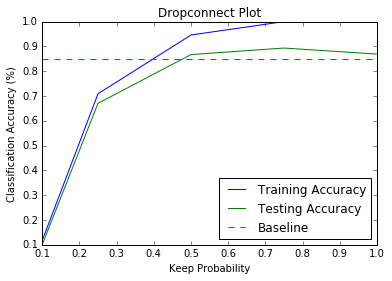

In [13]:
%matplotlib inline
plot_accuracy(BASELINE_ACC, keep_probs, train_acc, test_acc, title="Dropconnect Plot")

###### L1 Regularization

In [14]:
##### Reset the graph #####
tf.reset_default_graph()

_lambda = [0.1, 0.01, 0.001]

def run_l1():
    train_acc, test_acc = [], []
    # Declare computation graph
    y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
    x = tf.placeholder( tf.float32, [None, 784], name="x" )
    lambda_ = tf.placeholder(tf.float32)

    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    h1_reg = tf.reduce_prod(tf.abs(W1)) + tf.reduce_prod(tf.abs(b1))
    h1 = tf.nn.relu(tf.matmul( x, W1 ) + b1)

    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    h2_reg = h1_reg + tf.reduce_prod(tf.abs(W2)) + tf.reduce_prod(tf.abs(b2))
    h2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)

    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    h3_reg = h2_reg + tf.reduce_prod(tf.abs(W3)) + tf.reduce_prod(tf.abs(b3))
    h3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)

    W4 = weight_variable([1000, 10])
    b4 = bias_variable([10])
    final_reg = h3_reg + tf.reduce_prod(tf.abs(W4)) + tf.reduce_prod(tf.abs(b4))
    y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
    regularized_ce = cross_entropy + lambda_ * final_reg
    xent_summary = tf.scalar_summary( 'xent', cross_entropy )
    reg_ce_summary = tf.scalar_summary( 'reg_ce', regularized_ce )

    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc_summary = tf.scalar_summary( 'accuracy', accuracy )

    train_step = tf.train.AdamOptimizer(1e-4).minimize(regularized_ce)

    
    sess = tf.Session()
    for l in _lambda:
        sess.run(tf.initialize_all_variables())
        for _ in tqdm(range(150)):
            sess.run(train_step, feed_dict={ x: images, y_: labels, lambda_: l } )

        t_acc = sess.run(accuracy, feed_dict={ x: images, y_: labels, lambda_: l })
        final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, lambda_: l } )
        train_acc.append(t_acc)
        test_acc.append(final_acc)
        
    return train_acc, test_acc
        
train_acc, test_acc = run_l1()

100%|██████████| 150/150 [01:32<00:00,  1.62it/s]


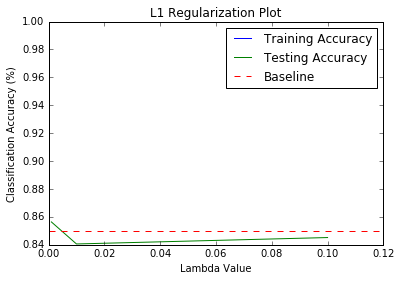

In [15]:
%matplotlib inline
plot_accuracy(BASELINE_ACC, _lambda, train_acc, test_acc, title="L1 Regularization Plot", xlabel="Lambda Value")